In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
import itertools as it
import warnings
warnings.filterwarnings('ignore')

In [2]:
price_train = pd.read_csv("house_price_train.csv")
price_test = pd.read_csv("house_price_test.csv")
feature_train = pd.read_csv("house_feature_train.csv")
feature_test = pd.read_csv("house_feature_test.csv")

train = pd.merge(price_train, feature_train)
test = pd.merge(price_test, feature_test)

# Q1a {-}
Develop a bagged decision tree model on the data *house_feature_train.csv* to predict *house_price*. Use all the predictors except *house_id*. Follow the steps below:

(i) Make a plot of out-of-bag RMSE (Root mean squared error) vs number of trees. *(3 points for code, 1 point for plot)* \
(ii) Based on the plot in (i), develop a bagged tree model with an appropriate number of trees. *(2 points for code)* \
(iii) Use the model developed in (ii) to predict house prices in *house_feature_test.csv*. Report the RMSE (should be less than 350). *(1 point for code, 1 point for answer)*



In [3]:
X = train.drop(columns = ['house_price', 'house_id'])
Xtest = test.drop(columns =  ['house_price', 'house_id'])
y = train['house_price']
ytest = test['house_price']

In [4]:
#Bagging the results of 10 decision trees to predict house price
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=10, random_state=1, n_jobs=-1).fit(X, y)

In [5]:
np.sqrt(mean_squared_error(test.house_price, model.predict(Xtest)))

358.7351329853139

In [6]:
oob_rsquared={};test_rsquared={};oob_rmse={};test_rmse = {}

#Finding model accuracy vs number of trees
for i in np.linspace(10,400,40,dtype=int):
        model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), 
                                 n_estimators=i, random_state=1, n_jobs=-1,oob_score=True).fit(X, y)
        oob_rsquared[i]=model.oob_score_  #Returns the out-of_bag R-squared of the model
        test_rsquared[i]=model.score(Xtest,ytest) #Returns the test R-squared of the model
        oob_rmse[i]=np.sqrt(mean_squared_error(y,model.oob_prediction_))
        test_rmse[i]=np.sqrt(mean_squared_error(ytest,model.predict(Xtest)))

C:\Users\nvsim\anaconda3\lib\site-packages\sklearn\ensemble\_bagging.py:1069: UserWarning: Some inputs do not have OOB scores. This probably means too few estimators were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


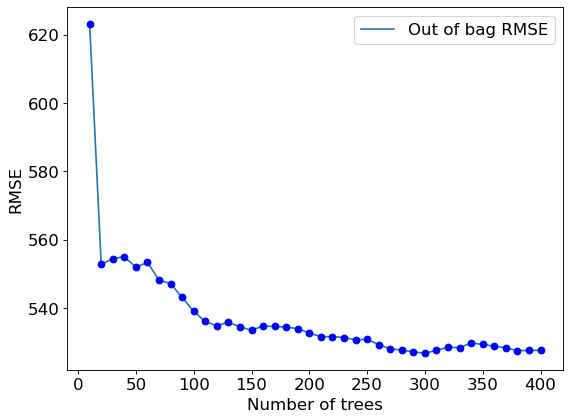

In [7]:
plt.rcParams.update({'font.size': 15})
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(oob_rmse.keys(),oob_rmse.values(),label = 'Out of bag RMSE')
plt.plot(oob_rmse.keys(),oob_rmse.values(),'o',color = 'blue')
plt.xlabel('Number of trees')
plt.ylabel('RMSE')
plt.legend()

In [8]:
#Bagging with 300 trees
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=300, random_state=1,
                        oob_score=True,n_jobs=-1).fit(X, y)

In [9]:
#RMSE on test data
pred = model.predict(Xtest)
np.sqrt(mean_squared_error(test.house_price, pred))

341.0988435793935

**The RMSE is 341.098.**

# Q1b {-}
Develop a random forest model on the data *house_feature_train.csv* to predict *house_price*. Use all the predictors except *house_id*. For tuning the model, compute the out-of-bag scores (OOB R-squared) for the following set of parameter values:

(i) Number of trees = \[75,100,125\] \
(ii) Number of predictors considered at each split: \[1,2,3,4,5\], \
(iii) Minimum number of observations required in a non-terminal node to split it: \[2,3,4,5,6\], \
(iv) Minimum number of observations required in a leaf: \[1,2,3\]


Use the parameter values corresponding to the highest OOB score to develop the model. Use the developed model to predict house prices in *house_feature_test.csv*. Report the RMSE (should be less than the RMSE in *Q1a*).

*(7 points for code, 1 point for answer)*

In [10]:
#Optimizing with OOB score takes half the time as compared to cross validation. 
#The number of models developed with OOB score tuning is one-fifth of the number of models developed with
#5-fold cross validation

n_samples = train.shape[0]
n_features = train.shape[1]

params = {'n_estimators': [75,100,125],
          'min_samples_leaf': [1,2,3],
          'min_samples_split':[2,3,4,5,6],
          'max_features': [1,2,3,4,5]}

param_list=list(it.product(*(params[Name] for Name in params)))

oob_score = [0]*len(param_list)
i=0
for pr in param_list:
    model = RandomForestRegressor(random_state=1,oob_score=True,verbose=False,n_estimators = pr[0],
                                 max_depth=pr[1],
                                  max_leaf_nodes=pr[2],max_features=pr[3],
                                  n_jobs=-1).fit(X,y)
    oob_score[i] = model.oob_score_
    i=i+1

print("Best params = ", param_list[np.argmax(oob_score)])
print("Best score (R-squared) = ", np.max(oob_score))

Best params =  (100, 3, 6, 4)
Best score (R-squared) =  0.7051914872582905


In [21]:
model = BaggingRegressor(base_estimator=DecisionTreeRegressor(min_samples_leaf=3, min_samples_split=6), n_estimators=100, max_features=4, random_state=1,oob_score=True,n_jobs=-1).fit(X, y)

In [22]:
#RMSE on test data
pred = model.predict(Xtest)
np.sqrt(mean_squared_error(test.house_price, pred))

331.27164312689786

**The RMSE is 331.27.**

# Q2 {-}
Refer to *Q2a of assignment 2*. Make an attempt to tune a random forest model (instead of a single decision tree model as in *Q2a of assignment 2* ) that has both **precision and recall higher than 40%** on *train.csv*, *test1.csv* and *test2.csv*. Attempt to tune the number of trees (`n_estimators`), and the number of predictors to consider at each split (`max_features`) to achieve the objective, but do not tune any parameters that prune trees (i.e., do not tune `max_depth`, `max_leaf_nodes`, `min_samples_split`, and `min_samples_leaf`, etc.).

Tune the parameters as follows. Compute the out-of-bag (OOB) precision for different parameter values of `n_estimators`, `max_features` and/or any other parameters that do not prune the tree, and choose the parameter values corresponing to the maximum OOB precision. Show that tuned model fails to meet the objective. You can show that by making a precision-recall plot for the tuned model, where both precision and recall are never simultaneously greater than 40%.

**Purpose of this exercise:** This exercise shows that pruning a single decision tree model may sometimes (though not usually) lead to a higher reduction in prediction variance (or a more accurate model), as compared to a random forest with unpruned trees. Thus,

(i) A random forest model can sometimes be further improved by pruning individual trees. \
(ii) A pruned tree may lead to enough reduction in prediction variance, so that developing a random forest with such pruned trees leads to negligible value addition (this can be shown by a similar exercise).

*(7 points for code, 1 point for the precision-recall plot of the optimized random forest model)*

In [36]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [30]:
train = pd.read_csv('train.csv')
test1 = pd.read_csv('test1.csv')
test2 = pd.read_csv('test2.csv')
X = train.drop(columns=['duration', 'y'])
X = pd.get_dummies(X)
y = pd.get_dummies(train['y'], drop_first=True)['yes']
X_test1 = test1.drop(columns=['duration', 'y', 'default'])
X_test1 = pd.get_dummies(X_test1)
y_test1 = pd.get_dummies(test1['y'], drop_first=True)['yes']
X_test2 = test2.drop(columns=['duration', 'y'])
X_test2 = pd.get_dummies(X_test2)
y_test2 = pd.get_dummies(test2['y'], drop_first=True)['yes']

In [31]:
start_time = time.time()

params = {'n_estimators': [325, 350, 375],
'max_features': range(1,6),
}
param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
precision = [0]*len(param_list)
i=0
for pr in param_list:
    model =RandomForestClassifier(random_state=1,oob_score=True,verbose=False,n_estimators= pr[0],
    max_features=pr[1], n_jobs=-1).fit(X,y)
    oob_pred = model.oob_decision_function_[:,1]
    bins=np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    precision[i] = 100*(cm[1,1])/(cm[0,1]+cm[1,1])
    i=i+1
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("max precision = ", np.max(precision))
print("params= ", param_list[np.argmax(precision)])

time taken =  1.5109307686487834  minutes
max precision =  39.33243121335138
params=  (350, 4)


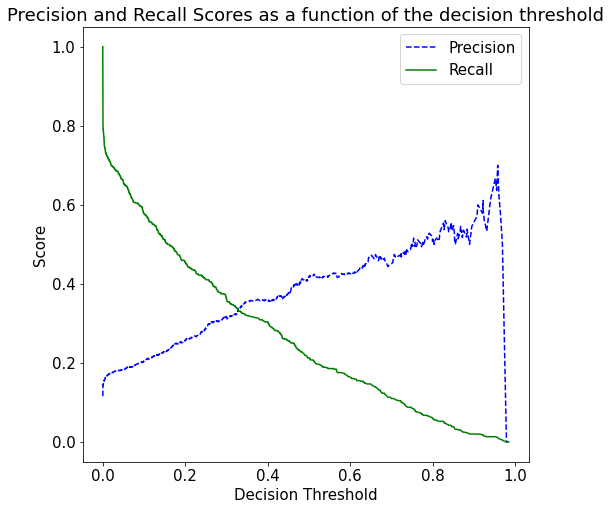

In [37]:
model = RandomForestClassifier(random_state=1, oob_score=True, n_estimators=350, max_features=4, verbose=False, n_jobs=-1).fit(X,y)
ypred = model.predict_proba(X_test1)[:, 1]
p, r, thresholds = precision_recall_curve(y_test1, ypred)
plot_precision_recall_vs_threshold(p, r, thresholds)

# Q3 {-}
We aim to classify stars as Galaxies or Quasars *(Quasars are extremely luminous active galactic nucleus, powered by a supermassive black hole)* based on their spectral characteristics. 
The data [(reference)](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17) consists of observations of space taken by the SDSS (Sloan Digital Sky Survey). Every observation is described by 9 feature columns and 1 class column which identifies it to be either a galaxy or quasar:

`alpha` = Right Ascension angle (at J2000 epoch) \
`delta` = Declination angle (at J2000 epoch) \
`u` = Ultraviolet filter in the photometric system \
`g` = Green filter in the photometric system \
`r` = Red filter in the photometric system \
`i` = Near Infrared filter in the photometric system \
`z` = Infrared filter in the photometric system \
`cam_col` = Camera column to identify the scanline within the run \
`class` = object class (galaxy or quasar object) \
`redshift` = redshift value based on the increase in wavelength

Develop and tune a random forest model using *Stellar_Classification_train.csv* to classify an observations as a Galaxy (*y=0*) or Quasar (*y=1*). The model must have a ROC-AUC of at least  99% on both  *Stellar_Classification_train.csv* and *Stellar_Classification_test.csv*. Print the ROC-AUC for both the datasets.

**Hint:** Consider 500 trees, and find the value of `max_features` that maximizes the out-of-bag (OOB) ROC-AUC.

*(7 points for code, 1 point for answer)*

In [40]:
train = pd.read_csv("Stellar_Classification_train.csv")
test = pd.read_csv("Stellar_Classification_test.csv")

In [43]:
X = train.drop(columns = 'class')
Xtest = test.drop(columns = 'class')
y = pd.get_dummies(train['class'])['QSO']
ytest = pd.get_dummies(test['class'])['QSO']

# Parameter Tuning
start_time = time.time()

params = {'max_features': range(1, 6)}
param_list=list(it.product(*(params[Name] for Name in list(params.keys()))))
roc_auc = [0]*len(param_list)
i=0
for pr in param_list:
    model =RandomForestClassifier(random_state=1,oob_score=True,verbose=False,n_estimators= 500,
    max_features=pr[0], n_jobs=-1).fit(X,y)
    oob_pred = model.oob_decision_function_[:,1]
    bins=np.array([0,0.5,1])
    cm = np.histogram2d(y, oob_pred, bins=bins)[0]
    fpr, tpr, auc_thresholds = roc_curve(y, oob_pred)
    roc_auc[i] = auc(fpr, tpr)
    i=i+1
    
end_time = time.time()
print("time taken = ", (end_time-start_time)/60, " minutes")
print("max roc_auc = ", np.max(roc_auc))
print("params= ", param_list[np.argmax(roc_auc)])

time taken =  1.3694956342379252  minutes
max roc_auc =  0.9885955918265144
params=  (3,)


In [46]:
model =RandomForestClassifier(random_state=1,oob_score=True,verbose=False,n_estimators= 500,max_features=3, n_jobs=-1).fit(X,y)

In [48]:
fpr, tpr, auc_thresholds = roc_curve(y, model.predict_proba(X)[:,1])
auc(fpr, tpr)

1.0

In [49]:
fpr, tpr, auc_thresholds = roc_curve(ytest, model.predict_proba(Xtest)[:,1])
auc(fpr, tpr)

0.990037663113758

**The ROC-AUC on the train data is 1.0. The ROC-AUC on the test data is 0.990037663113758.**

# Q4 {-}
Can a non-linear monotonic transformation of predictors (such as *log(), sqrt()* etc.) be useful in improving the accuracy of decision tree models?

*(3 points for answer)*

**No, non-linear monotonic transformation of predictors are not useful in improving the accuracy of decision models.**